In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [24]:
# Definizione delle funzioni
def retta(x, a, b):
    return a + b*x

def fitlinA_2(x, a, b):
    return a + b/x

def fit_nl_Tf(x, ft):
    return 1/np.sqrt(1 + (x/ft)**2)

def fit_nl_phi(x, ft):
    return np.arctan((x)/ft)

In [3]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [4]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

Vin = 8.16 # V
sVin = np.sqrt((0.03*Vin/(24**0.5))**2+(1/(25*24**0.5)))

Tf = data["Vch2"]/Vin
sTf = np.sqrt((0.03*data["Vch2"]/(24**0.5))**2+(1/(25*24**0.5)) + (data["Vch2"]/Vin * sVin)**2)/Vin # Assumo triangolare



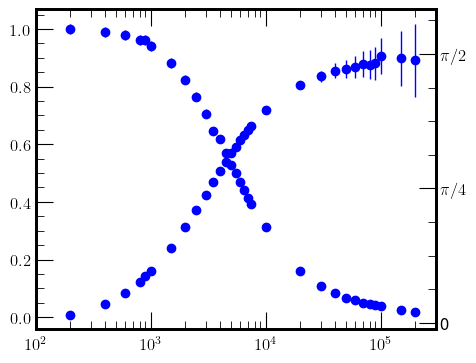

In [5]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='o')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='o')

axA.set_xlim(100,max(f)+10**5)

plt.show()

[3131.23225065] [[32.82638502]]
0.4395929349118177


[]

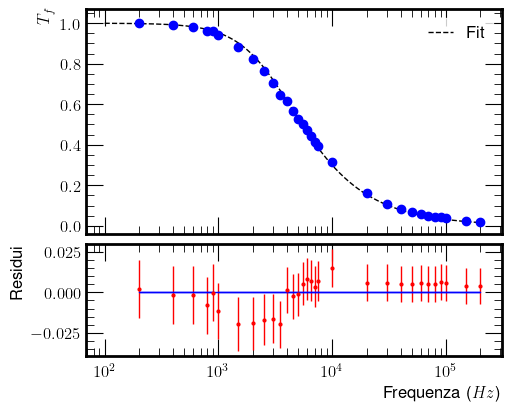

In [6]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_nl_Tf, f, Tf, p0=[3142], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr**0.5)

resTr = Tf - fit_nl_Tf(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_Tf(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()


[3256.51541375] [[8.92904488]]
14.475381458023348


[]

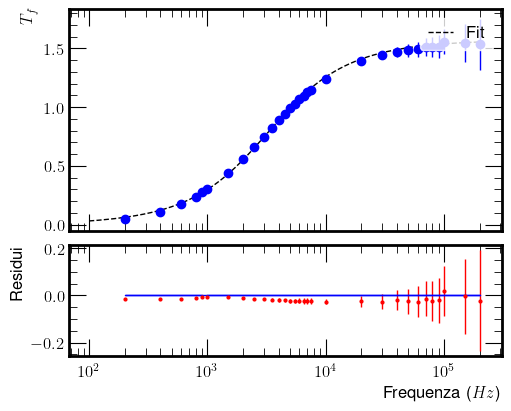

In [7]:
# Fit della fase non lineare
valphi, covphi = curve_fit(fit_nl_phi, f, phi, p0=[3106], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi**0.5)

resPhi = phi - fit_nl_phi(f, *valtr)
chi2phi = np.sum((resPhi/sphi)**2)

print(chi2phi/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_phi(x_fit, *valphi), label='Fit', linestyle='--', color='black')

ax[0].errorbar(f, phi, yerr=sphi, fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

ax[1].errorbar(f,resPhi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')

ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()


In [8]:
# Fit di Bode
valbode, covbode = curve_fit(retta, np.log10(f[f > 6e3]), 20*np.log10(Tf[f > 6e3]), method='lm' ,sigma=sTf[f > 6e3]/Tf[f > 6e3], absolute_sigma=True)

residuBode = Tf[f > 6e3] - 10**(retta(np.log10(f[f > 6e3]), *valbode)/20)
chi2bode = np.sum((residuBode/sTf[f > 6e3])**2)

print(chi2bode/(len(sTf[f > 6e3])-2))

print(valbode, '\n' , np.sqrt(np.diag(covbode)), '\n' , covbode) # Se voglio vedere i -20 dB su decade basta moltiplicare questo per 20

log_ftbode = (-valbode[0]/valbode[1])
slog_ftbode = log_ftbode * (covbode[0,0]/valbode[0]**2 + covbode[1,1]/valbode[1]**2 - 2*covbode[1,0]/(valbode[0]*valbode[1]))**0.5

print(round(10**log_ftbode), '+/-', round(10**(slog_ftbode+log_ftbode)-10**log_ftbode))

0.11598515773603355
[ 62.23521315 -18.16376358] 
 [0.26212153 0.06641143] 
 [[ 0.0687077  -0.01737957]
 [-0.01737957  0.00441048]]
2669 +/- 13


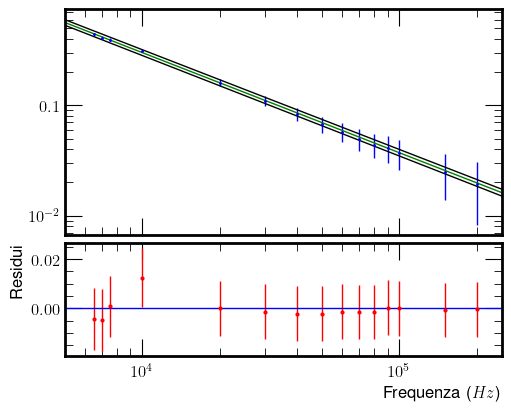

In [9]:
# Plot del fit di Bode
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])

x_fit = np.linspace(5e3, max(f)+5e4, 1000)

ax[0].errorbar(f[f > 6e3], Tf[f > 6e3], yerr=sTf[f > 6e3], fmt='o', ms=1)

ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *valbode)/20), color = "g")
ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode+np.sqrt(np.diag(covbode))))/20), color = "k")
ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode-np.sqrt(np.diag(covbode))))/20), color = "k")

ax[0].set_xlim(5e3, max(f)+5e4)

ax[0].loglog()

ax[1].errorbar(f[f > 6e3],residuBode,yerr=sTf[f > 6e3], fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(x_fit,np.zeros(len(x_fit)))



In [32]:
A_2 = Tf**-2
sA_2  = sTf / Tf ** 3

tgphi = np.tan(phi)
stgphi = sphi / np.cos(phi)**2

poptrlin, covtrlin = curve_fit(retta, f**2, A_2, method='lm' ,sigma=sA_2, absolute_sigma=True)
popphilin, covphilin = curve_fit(retta, f, tgphi, method='lm' ,sigma=stgphi, absolute_sigma=True)

df = len(f)-2

resA_2 = A_2 - retta(f**2, *poptrlin)
chi2A_2 = np.sum((resA_2/sA_2)**2)

restgPhilin = tgphi - retta(f, *popphilin)
chi2tgPhi = np.sum((restgPhilin/stgphi)**2)


print(chi2A_2/df)
print(chi2tgPhi/df)


print(poptrlin, covtrlin)
print(popphilin, covphilin)

print(poptrlin[1]**-0.5)
print(1/popphilin[1])


1.534808562155596
2.511233430891502
[1.02433914e+00 9.97668836e-08] [[ 5.29071758e-05 -3.05878690e-12]
 [-3.05878690e-12  1.26863603e-18]]
[-0.01292716  0.00031692] [[ 1.08133303e-06 -8.30660265e-10]
 [-8.30660265e-10  1.34861849e-12]]
3165.9700112282453
3155.320860126703


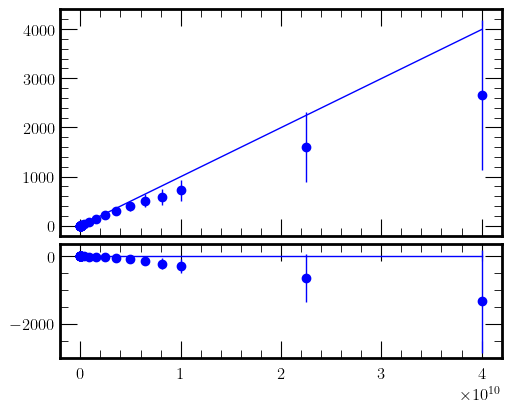

In [28]:
# Plot dei dati
fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
x_fit = np.linspace(min(f**2),max(f**2),100)

axA[0].errorbar(f**2, A_2, yerr=sA_2, fmt='bo')
axA[0].plot(x_fit, retta(x_fit, *poptrlin), color = "b")

axA[1].errorbar(f**2, resA_2, yerr=sA_2, fmt='bo')
axA[1].plot(x_fit, np.zeros(100), color = "b")


plt.show()

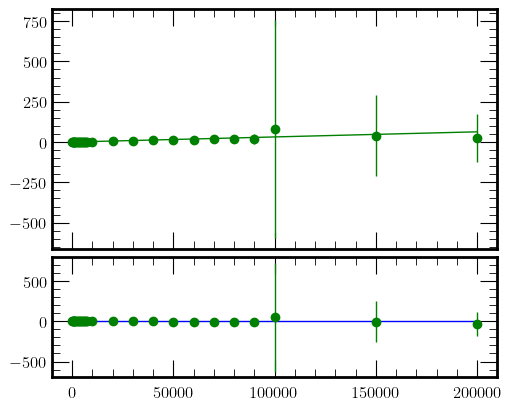

In [23]:
x_fit = np.linspace(min(f),max(f),100)

fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])

axA[0].plot(x_fit, retta(x_fit, *popphilin), color = "g")
axA[0].errorbar(f, tgphi,  yerr= stgphi, fmt='go')

axA[1].errorbar(f, restgPhilin, yerr=stgphi, fmt='go')
axA[1].plot(x_fit, np.zeros(100), color = "b")

plt.show()


In [50]:
# Importo il file con solo i dati locali intorno della frequenza di taglio
data = pd.read_csv('Dati locali.txt', sep="\t")
floc = data["f"]/1000 #kHz
philoc = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphiloc = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*6**0.5))

Vin = 8.16 # V
sVin = np.sqrt((1/(25*24**0.5)))

Tfloc = data["Vch2"]/Vin
sTfloc = np.sqrt(((1/(25*24**0.5)) + (data["Vch2"]/Vin * sVin)**2))/Vin # Assumo triangolare



In [51]:
# Fit linearizzato della f. di trasferimento in un intorno della ft (freq. di taglio)
valtrlin, covtrlin = curve_fit(retta, floc, Tfloc, method='lm' ,sigma=sTfloc, absolute_sigma=True)

a,b = valtrlin

ft_tr_lin = (2**-0.5 - a)/b

s_ft_tr_lin = np.sqrt((1/np.sqrt(2)-valtrlin[0])**2/valtrlin[1]**4*covtrlin[1,1]+1/valtrlin[1]**2*covtrlin[0,0]+2/valtrlin[1]**3*(1/np.sqrt(2)-valtrlin[0])*covtrlin[0,1])


print(ft_tr_lin,"+/-",s_ft_tr_lin, "kHz")

residutrlin = Tfloc - retta(floc, *valtrlin)
chi2lintr = np.sum((residutrlin/Tfloc)**2)

df = len(floc)-2

print(chi2lintr/df)

3.0466701582731033 +/- 0.03954453049206063 kHz
6.089970535218982e-05


In [52]:
# Fit linearizzato della fase in un intorno della ft (freq. di taglio)
valphilin, covphilin = curve_fit(retta, floc, philoc, method='lm' ,sigma=sphiloc, absolute_sigma=True)

residuPhilin = philoc - retta(floc, *valphilin)
chi2linPhi = np.sum((residuPhilin/sphiloc)**2)

df = len(floc)-2

print(chi2linPhi/df)

a,b = valphilin

ft_phi_lin = (np.pi/4 - a)/b

s_ft_phi_lin = np.sqrt((np.pi/4-valphilin[0])**2/valphilin[1]**4*covphilin[1,1]+1/valphilin[1]**2*covphilin[0,0]+2/valphilin[1]**3*(np.pi/4-valphilin[0])*covphilin[0,1])

print(ft_phi_lin,"+/-",s_ft_phi_lin, "kHz")


0.15956637955294375
3.415346422246687 +/- 0.03306794332303527 kHz


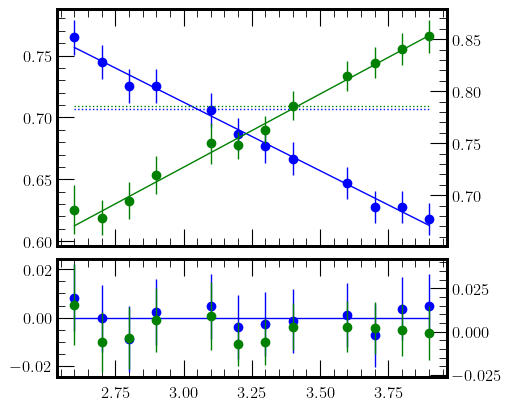

In [57]:
# Plot dei dati
fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
x_fit = np.linspace(min(floc),max(floc),100)
h = 0.1

axF = axA[0].twinx()

axA[0].errorbar(floc, Tfloc, yerr=sTfloc, fmt='bo')
axA[0].plot(x_fit, retta(x_fit, *valtrlin), color = "b")

axA[0].plot(x_fit, np.full(len(x_fit), 2**-0.5), linestyle = "dotted")

axF.plot(x_fit, retta(x_fit, *valphilin), color = "g")
axF.plot(x_fit, np.full(len(x_fit), np.pi/4), linestyle = "dotted", color = "g")

axF.errorbar(floc, philoc,  yerr= sphiloc, fmt='go')

axF2 = axA[1].twinx()


axA[1].errorbar(floc, residutrlin, yerr=sTfloc, fmt='bo')
axF2.errorbar(floc, residuPhilin, yerr=sphiloc, fmt='go')

axA[1].plot(x_fit, np.zeros(100), color = "b")


plt.show()

In [54]:
print((ft_phi_lin - ft_tr_lin)/np.sqrt(s_ft_phi_lin ** 2 + s_ft_tr_lin ** 2))

7.15201231400272
